In [1]:
using Sunny
using FFTW
using BinningAnalysis
using GLMakie
Makie.inline!(true)

# include plotting function for chirality heatmaps
include(joinpath(pkgdir(Sunny), "examples", "extra", "plotting2d.jl"))
z_mean(s1, s2, s3) = (s1[3] + s2[3] + s3[3]) / 3

z_mean (generic function with 1 method)

### The 'Okubo' model (https://arxiv.org/abs/1109.6161v2)

As an interesting example, let's look at a $J_1$-$J_3$ Heisenberg model on a triangular lattice with Hamiltonian: 

\begin{equation}
\mathcal{H} = J_1 \sum\limits_{\left<i,j\right>} \vec{S}_i\cdot\vec{S}_j + J_3\sum\limits_{\left<\left<i,j\right>\right>}\vec{S}_i\cdot\vec{S}_j - H\sum\limits_i\vec{S}_i 
\end{equation}

This should exhibit interesting skyrmion and spiral orderings.

In [2]:
# setup 2D triangular lattice
a, c = 1.0, 10.0
latvecs = lattice_vectors(a, a, c, 90, 90, 120)
positions = [[0, 0, 0]]
cryst = Crystal(latvecs, positions)

# setup 2D system 
L = 72
sys = System(cryst, (L, L, 1), [SpinInfo(1; S=1, g=1,)], :dipole, units=Units.theory, seed=0)
N = length(sys.dipoles)

# ferromagnetic nearest neighbor exchange interaction
J₁ = -1
set_exchange!(sys, J₁, Bond(1, 1, [1,0,0]))
# antiferromagnetic third-nearest neighbor exchange interaction
J₃ = 3.0 * abs(J₁)
set_exchange!(sys, J₃, Bond(1, 1, [2,0,0]))

# external magnetic field
h = 2.0 * J₃
set_external_field!(sys, [0, 0, h])

# start with random spin state
randomize_spins!(sys)

The initial (random) state looks like:

E = -0.08310324217542352


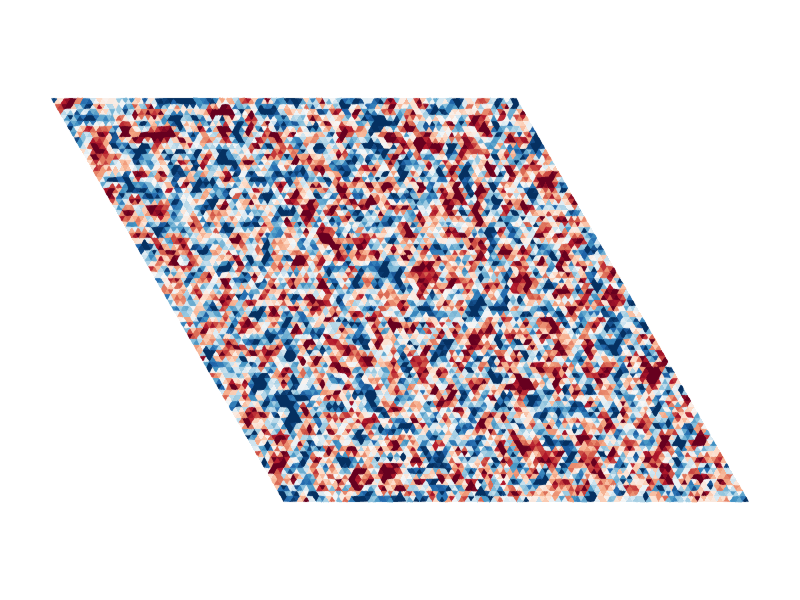

In [3]:
println("E = ", energy(sys)/N)
plot_triangular_plaquettes(z_mean, [sys.dipoles])

### Metropolis Algorithm

The goal is to sample states, $\boldsymbol{x}$, from the Boltzmann distribution $P(\boldsymbol{x}) \propto e^{-E(\boldsymbol{x})/(k_BT)}$ at some temperature.

We will use the Metropolis-Hastings algorithm (aka `LocalSampler`) to sample the desired temperature. This algorithm works by generating a random sequence of states from the target distribution by transitioning between states like

\begin{equation}
    p_{acc}(\boldsymbol{x}\rightarrow\boldsymbol{x'}) = \min\left(1,\; e^{-\Delta E/(k_BT)}\right) 
\end{equation}

The `LocalSampler` type contains the fields `\Delta E` and `\Delta s`, which track the net energy and magnetization differences over the sampler's MC steps. If you want to start with the values corresponding to the system's initial state rather than using a relative value, set these upon initialization.

There are 3 MC moves that come ready to use: `propose_uniform`, `propose_delta`, and `propose_flip`. You can implement your own update function that has the form: `(sys::System, site::Any, ...) -> ::SpinState`. The available updates are shown below:

![moves](mc.png)

Let's choose a temperature, $T/J_3 = 0.35$, where we can see a skyrmion crystal ordering.

In [4]:
# temperature where we want to measure
kT = 0.35 * J₃

# choose a mix of MC moves: 20% randomized on sphere, 80% on a spherical cap
move_proposal = @mix_proposals 0.2 propose_uniform 0.8 propose_delta(0.25) 

# use a metropolis sampler -- set the starting energy of the sampler to that of the system
sampler = LocalSampler(; kT, propose=move_proposal)
sampler.ΔE = energy(sys);

### Equilibration and Sampling at a Temperature

We will need to equilibrate the system to a configuration with an energy near the average for the desired temperature. A naive check is to visually examine a time series of the energy and see when it has settled on some average value. 

In practice, you will want to start with several independent initial states and see when they all converge on the same energy.

This will take about 20 seconds.

In [5]:
# number of sweeps in equilibration run
n_init = 50_000

# energy timeseries
Evt_init = zeros(n_init)

# perform equilibration with Metropolis MCMC
for i in 1:n_init
    step!(sys, sampler)
    Evt_init[i] = sampler.ΔE / N
end

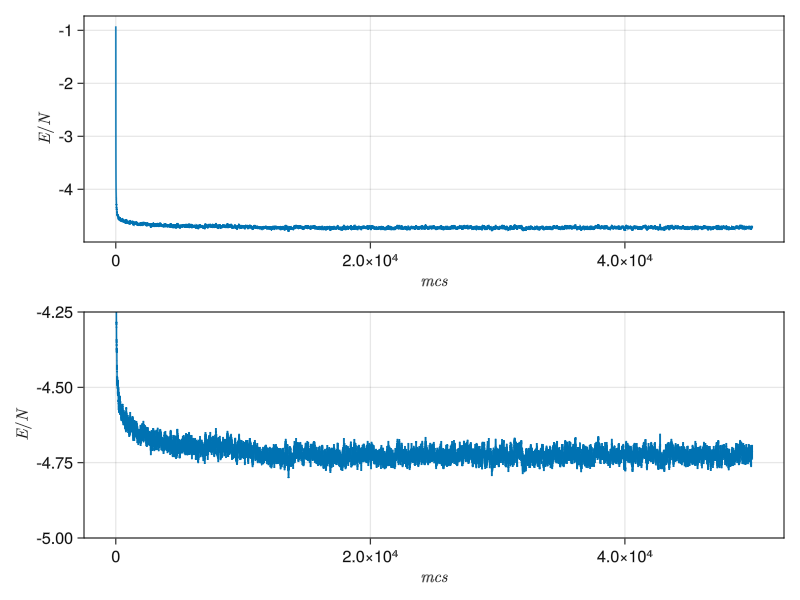

GLMakie.Screen(...)

In [6]:
# plot energy timeseries
fig = Figure()
lines(fig[1,1], 1:n_init, Evt_init, axis=(xlabel=L"mcs", ylabel=L"E/N"))
lines(fig[2,1], 1:n_init, Evt_init, axis=(xlabel=L"mcs", ylabel=L"E/N", limits=(nothing, (-5.0, -4.25))))
display(fig)

The equilibrated state looks like:

E = -4.739524021428054


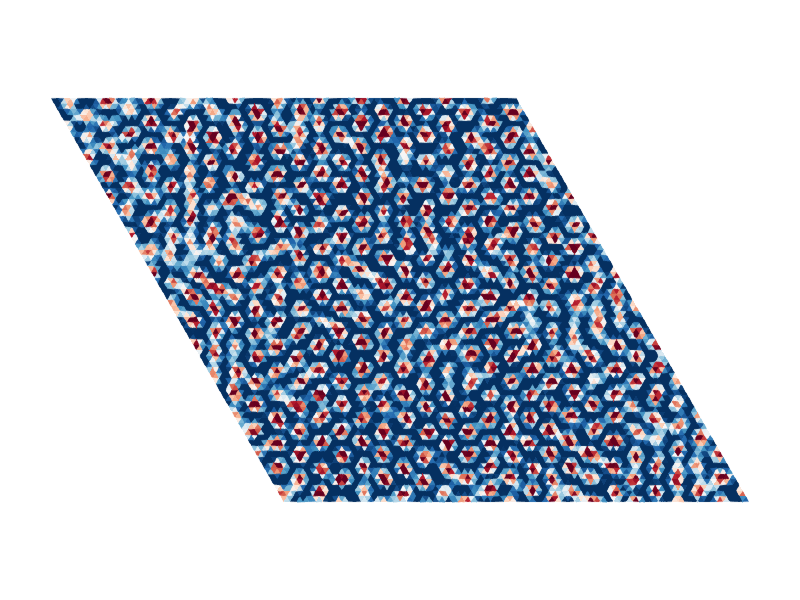

In [7]:
println("E = ", sampler.ΔE/N)
plot_triangular_plaquettes(z_mean, [sys.dipoles])

Now we can generate a bunch of states at the temperature of interest. In this example, we will look at the distribution of energies. This cell will take about 1.5 minute.

To help with this, Sunny has a 'Histogram' struct that is not exported, but can be accessed by `Sunny.Histogram`. Likewise for the convenience functions `Sunny.get_keys(::Histogram)` and `Sunny.get_vals(::Histogram)`.

This will take about 45 seconds.

In [8]:
# number of sweeps in measurement run
n_sample = 50_000
measure_interval = 1
n_measure = cld(n_sample, measure_interval)
sampler.nsweeps = measure_interval

# energy timeseries
Evt_sample = zeros(n_measure)

# energy histogram for visualizing distribution at specified temperature
E_hist = Sunny.Histogram(bin_size=1/N)

# perform Metropolis MCMC simulation
for i in 1:n_measure
    step!(sys, sampler)
    E = sampler.ΔE / N

    Evt_sample[i] = E
    E_hist[E] += 1
end

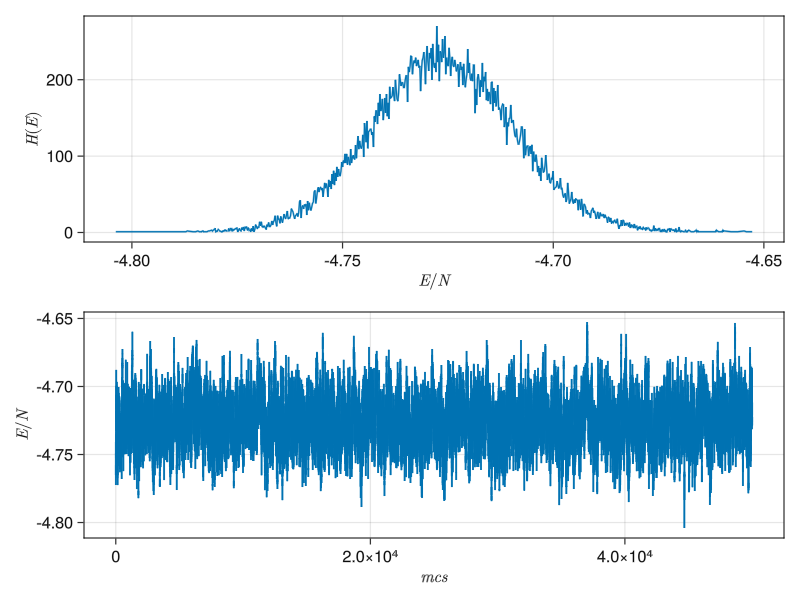

GLMakie.Screen(...)

In [9]:

# plot energy timeseries and distribution (histogram)
fig = Figure()
lines(fig[1,1], Sunny.get_keys(E_hist), Sunny.get_vals(E_hist), axis=(xlabel=L"E/N", ylabel=L"H(E)"))
lines(fig[2,1], 1:n_measure, Evt_sample, axis=(xlabel=L"mcs", ylabel=L"E/N"))
display(fig)

It can easily be seen from this that although you should take measurements from many states at the desired temperature to recover the thermal average. This is called an 'ensemble average', and is usually denoted by angled brackets. Ex: internal energy is the ensemble average of energy, $U = \left<E\right>$.

### Dealing with Correlations

When taking measurements from this distribution, it is important to consider how states in this sequence are correlated with respect to time. We want all of our measurements to be statistically independent. This is achieved by leaving a number of intermediate MC steps in between measurements. 

To quantify this, we typically look at a quantity called the autocorrelation function, $\mathcal{A}$, for an observable $\mathcal{O}$ with respect to a time displacement, $t$:

\begin{equation}
    \mathcal{A}(t) = \frac{\left<\mathcal{O}_i\mathcal{O}_{i+t}\right> - \left<\mathcal{O}_i\right>^2}{\left<\mathcal{O}_i^2\right> - \left<\mathcal{O}_i\right>^2}
\end{equation}

This helps us determine the integrated autocorrelation time, $\tau_{int}$, which dictates how many steps are needed to produce an independent measurement. $\tau_{int}$ is can be calculated as 

\begin{equation}
    \tau_{int}(t) = \frac{1}{2} + \sum_t \mathcal{A}(t)
\end{equation}

Looking at $\tau_{int}(t)$ for increasing $t$, the curve eventually levels out to a constant value, $\tau$. We typically want to space measurements out by $2\tau$.

The problem with this type of direct analysis, is that the quantities become extremely noisy with large $k$, and requires an average over many independent runs with many samples. 

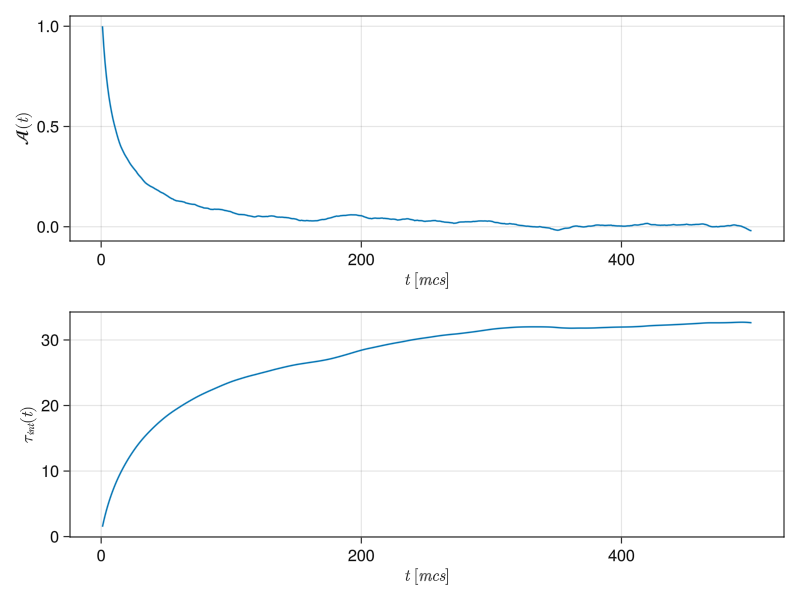

GLMakie.Screen(...)

In [10]:
# calculate autocorrelation function over full dataset 'x'
function autocorrelation(x::Vector{Float64})
    N = length(x)
    μ = sum(x)/N
    σ² = sum(x .^ 2)/N - μ^2

    S = FFTW.ifft(abs2.(FFTW.fft([x .- μ; zeros(N)])))
    return real.(S[1:N]) ./ (N * σ²)
end

# calculate autocorrelation function for energy
A = autocorrelation(Evt_sample)
# calculate integrated autocorrelation time from correlation function
τ_int = 1/2 .+ cumsum(A)
# maximum time displacement to plot autocorrelation 
max_lag = 500

# plot correlation function and integrated autocorrelation time for some time interval
fig = Figure()
lines(fig[1,1], 1:max_lag, A[1:max_lag], axis=(xlabel=L"t\;[mcs]", ylabel=L"\mathcal{A}(t)"))
lines(fig[2,1], 1:max_lag, τ_int[1:max_lag], axis=(xlabel=L"t\;[mcs]", ylabel=L"\tau_{int}(t)"))
display(fig)

Alternatively, we can estimate the autocorrelation time through a binning analysis from a single simulation. The basic idea is that if the sequence of states from a simulation can be divided into large enough chunks, or 'bins', then $\tau$ can be estimated from the variance of these bins. The quality of the estimated $\tau$ will depend on how many data are collected in the initial MC run.

There is a nice Julia package, BinningAnalysis.jl (https://github.com/carstenbauer/BinningAnalysis.jl), which implements this binning analysis in a memory-efficient way. We recommend this tool to estimate autocorrelation times with Sunny simulations. If you try to use the binning analysis before the system is equilibrated, the resulting $\tau$ will be overestimated.

In [11]:
# calculate integrated autocorrelation time from binner
binner = LogBinner(Evt_sample)

τ_binned = tau(binner)
println("τ = ", τ_binned, " at T/J₃ = 0.35")

τ = 29.645143392383495 at T/J₃ = 0.35


### Practical Considerations for Metropolis MC:

With low temperatures, the transition probability between states looks like:

\begin{equation}
    p_{acc}(\boldsymbol{x}\rightarrow\boldsymbol{x}')
    \begin{cases}
        1, & \text{if } E(\boldsymbol{x}') \leq E(\boldsymbol{x})\\
        0, & \text{if } E(\boldsymbol{x}') > E(\boldsymbol{x})
    \end{cases}
\end{equation}

This leads to the system getting 'frozen' into a state, as any spin update will increase the energy before a new minimum can be found.